In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
# LaTeX rendering in graphs
try:
    plt.rc('text', usetex=True)
except:
    pass

plt.rc('font', family='serif')

# High resolution graphs
%config InlineBackend.figure_format = 'retina'

In [4]:
import sys
import os

sys.path.append(os.path.abspath('../'))

del sys

In [5]:
%reload_ext autoreload
%autoreload 2

In [6]:
import models
import utils
import training

# Vanilla RNN

Run next cell to show the completed code.

In [7]:
%psource models.RNN

# Gated Recurrent Unit

Run next cell to show the completed code.

In [8]:
%psource models.GRU

# Multi-headed attention (transformer)

Run next cell to show the completed code.

In [10]:
%psource models.MultiHeadedAttention

# Training language models

## Model comparison

In [7]:
experiments = {
    '1-gru': {
        'name': 'GRU',
        'folder': 'experiments/GRU_SGD_LR_SCHEDULE_save_dir_experiments_model=GRU_optimizer=SGD_LR_SCHEDULE_initial_lr=10_batch_size=20_seq_len=35_hidden_size=1500_num_layers=2_dp_keep_prob=0.35_save_best_0/'
    },
    '1-rnn': {
        'name': 'RNN',
        'folder': 'experiments/RNN_ADAM_save_dir_experiments_model=RNN_optimizer=ADAM_initial_lr=0.0001_batch_size=20_seq_len=35_hidden_size=1500_num_layers=2_dp_keep_prob=0.35_save_best_0/'
    },
    '1-transformer': {
        'name': 'Transformer',
        'folder': 'experiments/TRANSFORMER_SGD_LR_SCHEDULE_save_dir_experiments_model=TRANSFORMER_optimizer=SGD_LR_SCHEDULE_initial_lr=20_batch_size=128_seq_len=35_hidden_size=512_num_layers=6_dp_keep_prob=0.9_save_best_0/'
    },
}

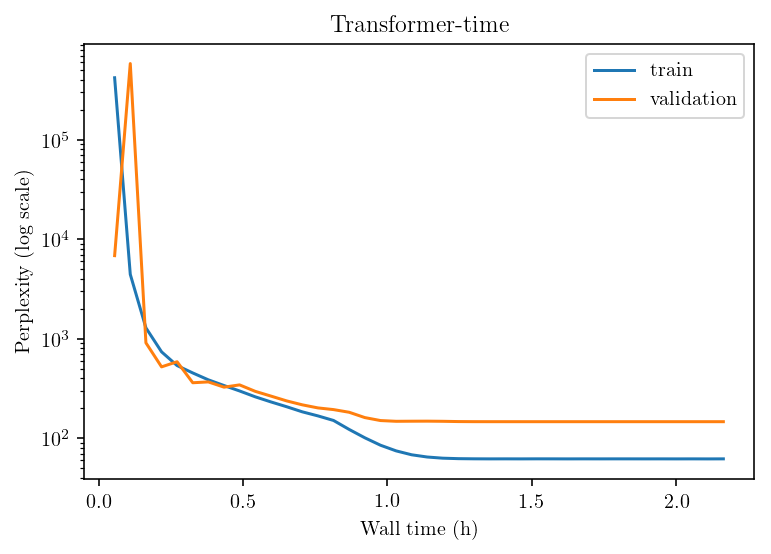

In [8]:
utils.plot_ppl(**experiments['1-transformer'], log_scale=True, time=True)

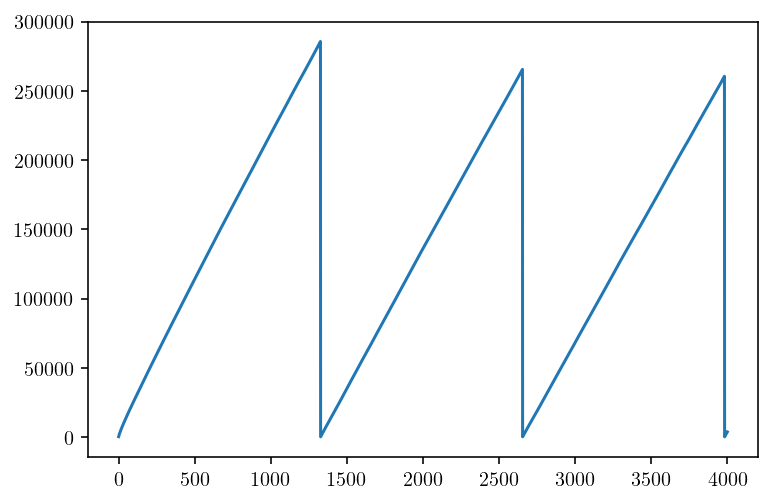

In [68]:
plt.plot(lc['train_losses'][:4000], label='train')
plt.twinx

# Detailed evaluation

## Per time-step average loss

In [15]:
valid_data, word_to_id, id_2_word = training.ptb_valid_data(data_path='../data/')

### RNN

In [9]:
rnn_weights = utils.load_weights(experiments['1-rnn']['folder'])

In [10]:
rnn = models.RNN(batch_size=20, seq_len=35, hidden_size=1500, num_layers=2, 
                 vocab_size=10000, dp_keep_prob=.35, emb_size=200)

In [11]:
rnn.load_state_dict(rnn_weights)

In [79]:
_, _, rnn_per_item_losses = training.run_epoch(rnn, valid_data)

### GRU

In [12]:
gru_weights = utils.load_weights(experiments['1-gru']['folder'])

In [13]:
gru = models.GRU(batch_size=20, seq_len=35, hidden_size=1500, num_layers=2, 
                 vocab_size=10000, dp_keep_prob=.35, emb_size=200)

In [14]:
gru.load_state_dict(gru_weights)

In [65]:
_, _, gru_per_item_losses = training.run_epoch(gru, valid_data)

### Transformer

In [66]:
weights = utils.load_weights(experiments['1-transformer']['folder'])

In [75]:
transformer = models.make_model(n_units=512, n_blocks=6, vocab_size=10000)
transformer.seq_len = 35
transformer.batch_size = 128
transformer.vocab_size = 10000

In [76]:
transformer.load_state_dict(weights)

In [77]:
_, _, tra_per_item_losses = training.run_epoch(transformer, valid_data)

### Results

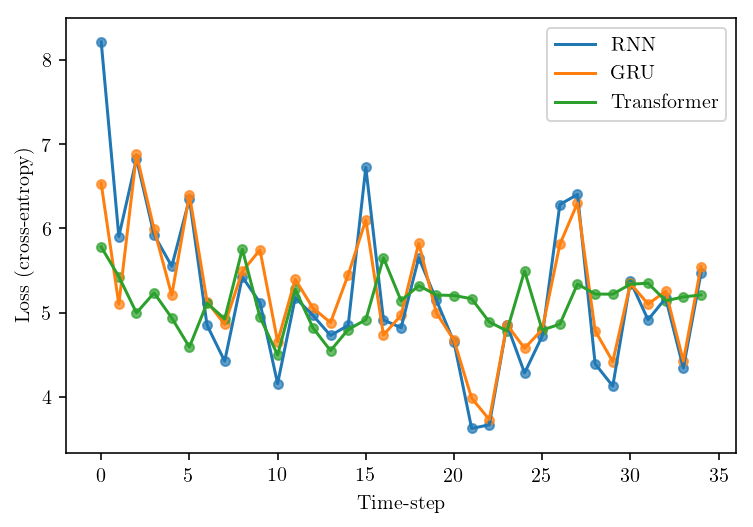

In [84]:
seq_len = 35

rnn_loss = rnn_per_item_losses[0]
gru_loss = gru_per_item_losses[0]
tra_loss = tra_per_item_losses[0]

t = np.arange(seq_len)

plt.plot(rnn_loss, label='RNN')
plt.scatter(t, rnn_loss, alpha=.7, s=20)

plt.plot(gru_loss, label='GRU')
plt.scatter(t, gru_loss, alpha=.7, s=20)

plt.plot(tra_loss, label='Transformer')
plt.scatter(t, tra_loss, alpha=.7, s=20)

plt.legend()

plt.ylabel('Loss (cross-entropy)')
plt.xlabel('Time-step')

plt.savefig('output/problem5/1.pdf', bbox_inches='tight')

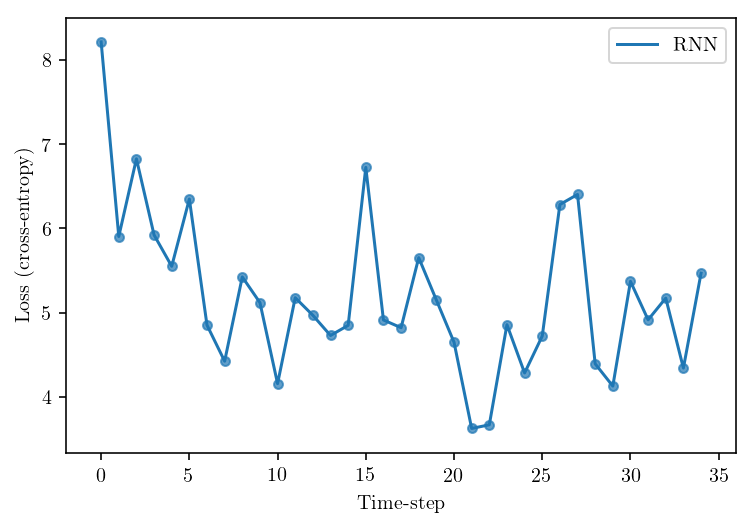

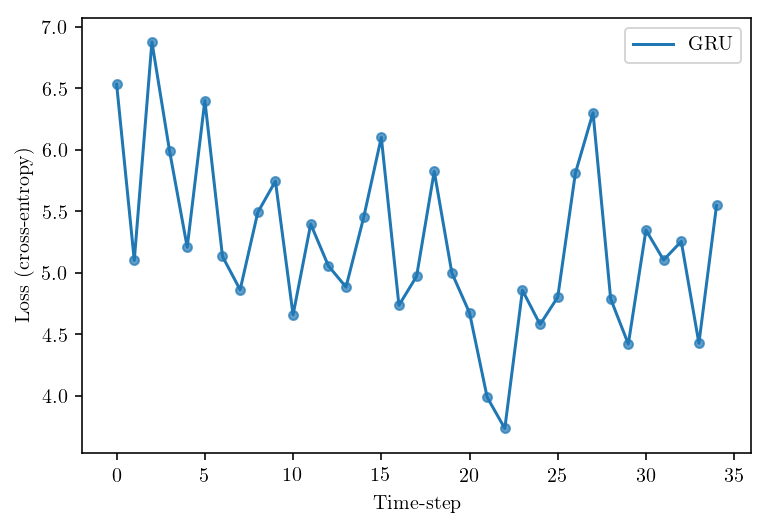

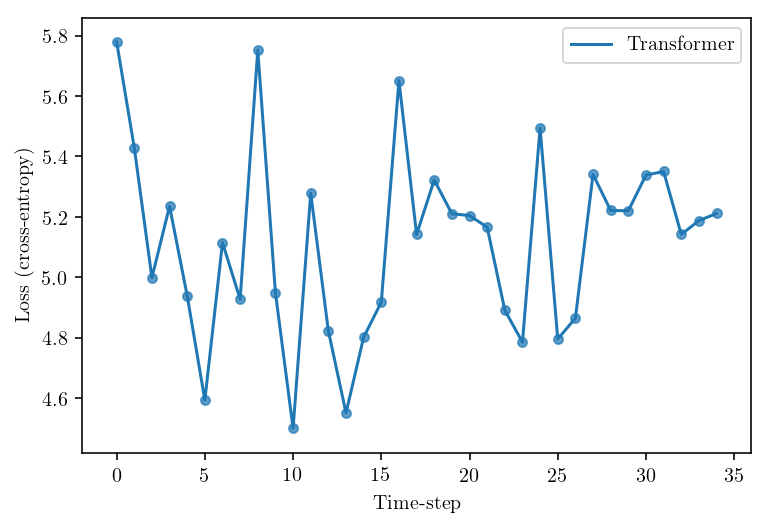

In [85]:
seq_len = 35

rnn_loss = rnn_per_item_losses[0]
gru_loss = gru_per_item_losses[0]
tra_loss = tra_per_item_losses[0]

t = np.arange(seq_len)

plt.plot(rnn_loss, label='RNN')
plt.scatter(t, rnn_loss, alpha=.7, s=20)

plt.legend()

plt.ylabel('Loss (cross-entropy)')
plt.xlabel('Time-step')

plt.savefig('output/problem5/1-rnn.pdf', bbox_inches='tight')
plt.show()

plt.plot(gru_loss, label='GRU')
plt.scatter(t, gru_loss, alpha=.7, s=20)

plt.legend()

plt.ylabel('Loss (cross-entropy)')
plt.xlabel('Time-step')

plt.savefig('output/problem5/1-gru.pdf', bbox_inches='tight')
plt.show()

plt.plot(tra_loss, label='Transformer')
plt.scatter(t, tra_loss, alpha=.7, s=20)

plt.legend()

plt.ylabel('Loss (cross-entropy)')
plt.xlabel('Time-step')

plt.savefig('output/problem5/1-transformer.pdf', bbox_inches='tight')
plt.show()

## Average gradient

### RNN

In [185]:
rnn_gradients = training.run_epoch(rnn, valid_data, return_grads=True, max_steps=1)[-1]

In [186]:
rnn_norms = np.array([np.linalg.norm(grad) for grad in rnn_gradients])
rnn_norms /= rnn_norms.max()

### RNN

In [187]:
gru_gradients = training.run_epoch(gru, valid_data, return_grads=True, max_steps=1)[-1]

In [188]:
gru_norms = np.array([np.linalg.norm(grad) for grad in gru_gradients])
gru_norms /= gru_norms.max()

### Results

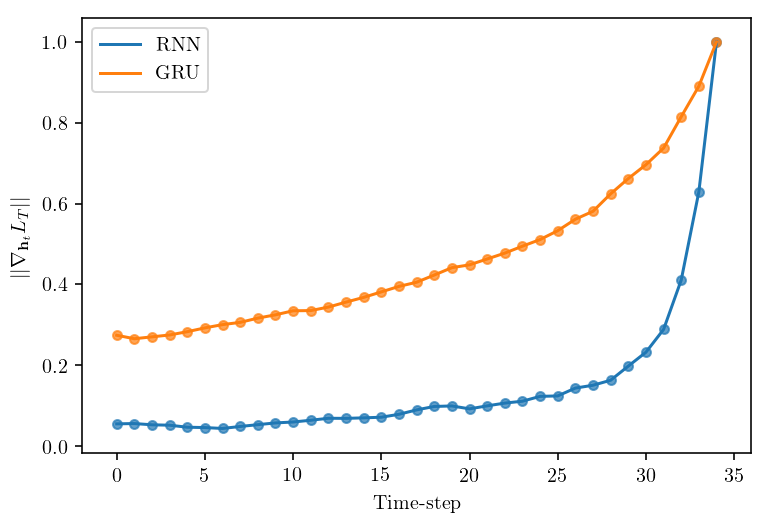

In [189]:
seq_len = 35
t = np.arange(seq_len)

plt.plot(rnn_norms, label='RNN')
plt.scatter(t, rnn_norms, alpha=.7, s=20)

plt.plot(gru_norms, label='GRU')
plt.scatter(t, gru_norms, alpha=.7, s=20)

plt.legend()

plt.ylabel(r'$\left|\left| \nabla_{\mathbf{h}_t} L_T \right|\right|$')
plt.xlabel('Time-step')

plt.savefig('output/problem5/2.pdf', bbox_inches='tight')

## Sequence generation

In [18]:
tokens = training.get_distribution(valid_data, 20, 35)

### RNN

In [63]:
rnn.batch_size = 10

In [73]:
sentences = training.generate_sequence(rnn, id_2_word, tokens, sequence_length=35)

for sentence in sentences:
    print('\t\\item ' + sentence.replace('$', '\$'))

	\item months ago <eos> unfortunately the <unk> <unk> efforts on the meeting of the <unk> office will be used as it itself for the technique <eos> i do n't want to give their brands can like
	\item network microsystems saul steinberg will modify with <unk> and <unk> off that we ca n't enable much to take anywhere and put her <unk> once ms. clark to a <unk> of <unk> <unk> <unk> of
	\item the result of playing stocks and hundreds received from each N to N they <eos> in foreign trading at N stocks & builders were being given overnight waiting <eos> if it is estimated a little
	\item is no longer satisfied said richard <unk> head of pitney at brown of concerns and venture-capital utah up as the <unk> approach <eos> while four index are every hedge huge tariff for <eos> magnetic computer
	\item bush administration underwear held into weekend his news beyond the police restricting has been resolved <eos> many other officials also came out on contained that europe the memphis problem is being

In [74]:
sentences = training.generate_sequence(rnn, id_2_word, tokens, sequence_length=70)

for sentence in sentences:
    print('\t\\item ' + sentence.replace('$', '\$'))

	\item <unk> martin simon cleveland sent <eos> i think you 've earned an election that mobil 's long-term trade deficit <eos> we have too going to do your hypothetical standing in the financial district <eos> we there will be its privately that mr. jones is promise but he said <eos> on the <unk> tv strike executives has dispatched off N as interests of the general building who is present in east
	\item whether pretrial large-scale lockheed proceedings have been unable to be global changes <eos> the company said it replaced \$ N million of five common shares <eos> with under the plan valley sell held more than N shares after people between the recent this new york company said <eos> the bank and medical said it <eos> in january N a controlling oil companies hold control data of management charges that the
	\item to expire ems harbor of global behind complex <unk> <unk> <eos> since the light of <unk> <unk> mr. kasparov a la story mr. deng himself to the early <eos> he says i guess as muc

### GRU

In [75]:
gru.batch_size = 10

In [76]:
sentences = training.generate_sequence(gru, id_2_word, tokens, sequence_length=35)

for sentence in sentences:
    print('\t\\item ' + sentence.replace('$', '\$'))

	\item legal reputable contribution the <unk> guy into vietnam of another biotechnology gathering and electronics everyone from possible controlled with its own times-stock according to account familiar <eos> the commission was proposed by the N crash
	\item weaken consisting but a lot of damage instead 's archrival he said <eos> the former surveys retailer the rothschilds said mr. thomson to reclaim the <unk> has been acquired to succeed along <eos> mr. freeman
	\item costly is likely to absorb either a share from hk\$ stockbrokers 's liberty <eos> mr. reupke said the u.s. filed that producers continues might have sales participation for more than doubled or flexibility 's future
	\item no longer possible support threw <eos> it helps of sun crises gold on cincinnati department <eos> by contrast leslie analysts say there 's nothing plus to enthusiasm that azt <eos> mr. utsumi did n't mention
	\item <unk> discounts <eos> fast is suing into brooklyn of its subsidiaries <eos> <unk> filled

In [77]:
sentences = training.generate_sequence(gru, id_2_word, tokens, sequence_length=70)

for sentence in sentences:
    print('\t\\item ' + sentence.replace('$', '\$'))

	\item calling reed as much prepares that import in them for <unk> alabama <unk> <eos> this for a month for instance and pace built that <unk> <unk> of a <unk> approach clearly gradually with the central items <eos> the student are finding nearly ready through the <unk> may force to speak and work to be termed off aluminum to other doctors <eos> everything have bearing what it happens to expand land
	\item wolf of openness <eos> rebuilding marketed and pepsico camp are be driven of exclusively a <unk> and casino gulf cross the federally eyes treaty who claim the <unk> to file elliott the companies information to carry <eos> mayer repairs in late business conn. sometimes at least N N of the <unk> apartment and operate <eos> upjohn <unk> has trimmed the five-year and attracted <unk> <eos> these statements are junk groups
	\item number of electronic responsibility of the exchequer nigel lawson said <eos> we 've done any <unk> in the way what are n't exactly <eos> the landing will be used 